# Steady State Response

Based on the data that are obtained, they will be fitted to the function below

$\displaystyle{ \hat{u}_s = \beta_1 \left(1 - e^{\beta_2 v_s + \beta_3 \sqrt[10]{v_s}} \right) }$

where $u_s$ is throttle, $v_s$ is steady-state speed for a constant input, and $\beta_1, \beta_2, \beta_3 \in \Re$

The cost function that will be minimized using PSO, APSO, and BSO is stated below

$ \displaystyle{
J = \frac{1}{M} \sum_{i=1}^M \left(u_s - \hat{u}_s \right)^2
} $

The constraints that will be used when minimizing are

$ \displaystyle{
    \beta_1 \geq 0
} $

$\displaystyle{
\beta_2, \beta_3 \leq 0
}$

## Import Libraries and Data

In [43]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from numba import jit, njit, types, vectorize, prange
from numba import jitclass, int32, float32, int64, float64
from numba.typed import List
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join

In [14]:
df = pd.read_csv('data/steady_state_velocity.csv')
v0 = np.array(df.speed[1:])
u0 = np.array(df.throttle[1:])

## Data Plot

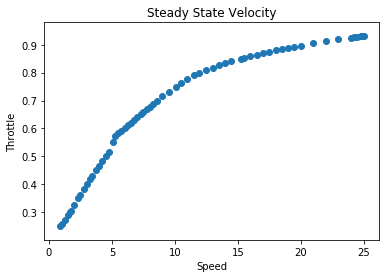

In [15]:
plt.title('Steady State Velocity')
plt.xlabel('Speed')
plt.ylabel('Throttle')
plt.scatter(v0, u0)
plt.show()

## Functions

Cost Function

In [41]:
@njit
def cost(beta):
    u = beta[0]*(1.0 - np.exp(beta[1]*v0 + beta[2]*v0**(0.1)))
    err = np.absolute(u - u0)
    return np.mean(err**2)

_ = cost(np.array([0.1,0.1,0.1]))

Evaluation Function (for plotting results)

In [40]:
@njit
def ev_func(beta):
    b1, b2, b3 = param
    u = b1*(1.0 - np.exp(b2*v0 + b3*v0**(0.1)))
    return u

_ = cost([0.1,0.1,0.1])

PSO Algorithm

In [45]:
@njit
def PSO(c_func, n_param, particles, lb, ub, iterate_max):
    # Define the constants
    w = 0.5
    c1 = 0.8
    c2 = 0.7
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = np.random.uniform(lb, ub, (particles, n_param))
    pbest_pos = ppos_vector
    pfit_value = np.ones(particles) * 1e100
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    pvel_vector = np.zeros((particles, n_param))
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
        
    # Second loop for implementing the PSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the velocity and position vector
            pvel_vector[i] = w*pvel_vector[i] + c1*random.random()*(pbest_pos[i]-ppos_vector[i]) + c2*random.random()*(gbest_pos-ppos_vector[i])
            ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
            
            cost_func = c_func(ppos_vector[i])
            
            # Update each values using the cost functions
            if(pfit_value[i] > cost_func):
                pfit_value[i] = cost_func
                pbest_pos[i] = np.copy(ppos_vector[i])
                
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    print(c_func(gbest_pos))
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return ppos_vector, gbest_pos

_ = PSO(cost, 3, 1, 0, 1, 1)

Iteration:  1  | Global best cost:  1010872329417882.9
1010872329417882.9
The best position for each parameter:  [0.27717281 0.77280671 0.49841267]  with  1  iteration.


APSO Algorithm